In [1]:

# GDP Forecasting for Multiple Countries using Machine Learning and Time Series Models

# File Path (Local)
data_path = "/Users/pratyushsingh/Downloads/Extended_GDP_2018_2023.csv"

# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv(data_path)
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
df = pd.melt(df, id_vars=id_vars, var_name='year', value_name='GDP')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna()
df['year'] = df['year'].astype(int)
df.rename(columns={'Country Name': 'Country'}, inplace=True)
df = df[['Country', 'year', 'GDP']]

# Target countries
countries = ['Mexico', 'United States', 'Spain', 'Canada', 'India', 'China']
future_years = np.arange(2024, 2031).reshape(-1, 1)

# Models
total_results = []
model_dict = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'Support Vector Regression': SVR(kernel='rbf', C=1e3, gamma=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0)
}

# Model Execution
for country in countries:
    df_country = df[df['Country'] == country].sort_values(by='year')
    X = df_country['year'].values.reshape(-1, 1)
    y = df_country['GDP'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    future_poly = poly.transform(future_years)

    for model_name, model in model_dict.items():
        try:
            if model_name == 'Polynomial Regression':
                model.fit(X_train_poly, y_train)
                preds = model.predict(X_test_poly)
                future_preds = model.predict(future_poly)
            elif model_name == 'Support Vector Regression':
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)

            r2 = r2_score(y_test, preds)

            for i, year in enumerate(future_years.flatten()):
                total_results.append({
                    'Country': country,
                    'Model': model_name,
                    'Year': year,
                    'Forecasted GDP': future_preds[i],
                    'R2 Score': r2
                })

        except Exception as e:
            continue

    # Add ARIMA Model
    try:
        arima_model = ARIMA(y_train, order=(2, 1, 2)).fit()
        arima_forecast = arima_model.forecast(steps=len(future_years))
        arima_preds = arima_model.forecast(steps=len(y_test))
        arima_r2 = r2_score(y_test, arima_preds)

        for i, year in enumerate(future_years.flatten()):
            total_results.append({
                'Country': country,
                'Model': 'ARIMA',
                'Year': year,
                'Forecasted GDP': arima_forecast[i],
                'R2 Score': arima_r2
            })
    except:
        pass

# Create forecast DataFrame
forecast_df = pd.DataFrame(total_results)

# Save to CSV
forecast_df.to_csv("GDP_Forecasts_2024_2030.csv", index=False)

# Visualizations
plt.figure(figsize=(14, 7))
sns.boxplot(data=forecast_df, x='Model', y='R2 Score')
plt.title('R² Score Comparison Across Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line plots for each country
for country in countries:
    plt.figure(figsize=(12, 5))
    subset = forecast_df[forecast_df['Country'] == country]
    for model in subset['Model'].unique():
        model_data = subset[subset['Model'] == model]
        plt.plot(model_data['Year'], model_data['Forecasted GDP'], label=model)
    plt.title(f"{country} GDP Forecast (2024–2030)")
    plt.xlabel("Year")
    plt.ylabel("Forecasted GDP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/pratyushsingh/Downloads/Extended_GDP_2018_2023.csv'

Feature Selection Using Lasso Regression 

Selected Features using Lasso Regression:
Indicator Name
Unemployment, male (% of male labor force) (modeled ILO estimate)                                 3.163189
Unemployment, female (% of female labor force) (modeled ILO estimate)                             2.095501
Labor force, female (% of total labor force)                                                      0.255785
Population ages 0-14 (% of total population)                                                      0.025682
Lower secondary school starting age (years)                                                       0.021811
Population ages 15-64 (% of total population)                                                     0.015304
Preprimary education, duration (years)                                                            0.013325
Labor force, total                                                                                0.010959
Secondary education, pupils                                                            

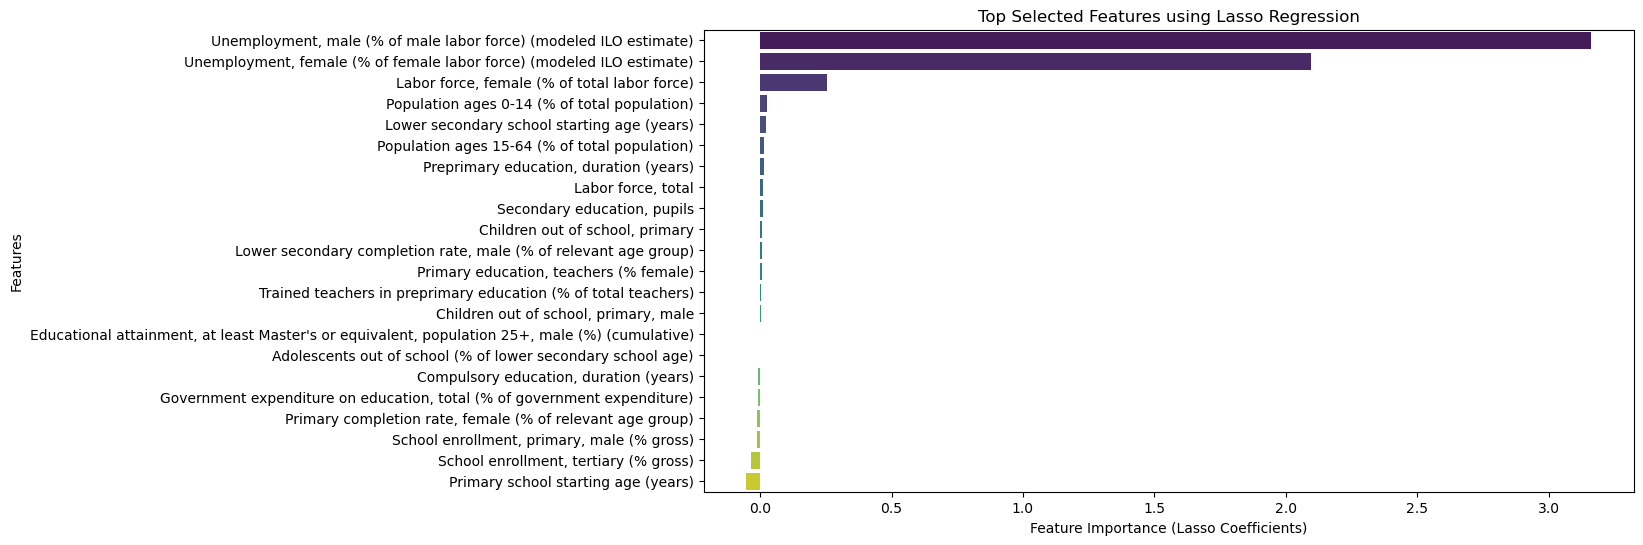

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_excel("/Users/pratyushsingh/Downloads/Reshaped_Dataset_2000_2023.xlsx", engine="openpyxl")  

# Pivot the dataset if necessary (depends on structure)
df_pivot = df.pivot_table(index=["Country Name", "Year"], columns="Indicator Name", values="Value")
df_pivot.reset_index(inplace=True)

# Drop non-numeric columns
df_clean = df_pivot.drop(columns=["Country Name", "Year"], errors='ignore')

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy="mean")
df_imputed = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# Define target variable (e.g., Unemployment Rate) and features
target_variable = "Unemployment, total (% of total labor force) (modeled ILO estimate)"
y = df_imputed[target_variable]
X = df_imputed.drop(columns=[target_variable])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply Lasso Regression (embedded feature selection)
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Get feature importance (non-zero coefficients)
feature_importances = pd.Series(lasso.coef_, index=X.columns)
selected_features = feature_importances[feature_importances != 0]  # Keeping only important features

# Sort features by importance
selected_features = selected_features.sort_values(ascending=False)

# Display selected features
print("Selected Features using Lasso Regression:")
print(selected_features)

# *Plot Feature Importance*
plt.figure(figsize=(12, 6))
sns.barplot(x=selected_features.values, y=selected_features.index, palette="viridis")
plt.xlabel("Feature Importance (Lasso Coefficients)")
plt.ylabel("Features")
plt.title("Top Selected Features using Lasso Regression")
plt.show()


GDP Forecasting With Multiple Models 

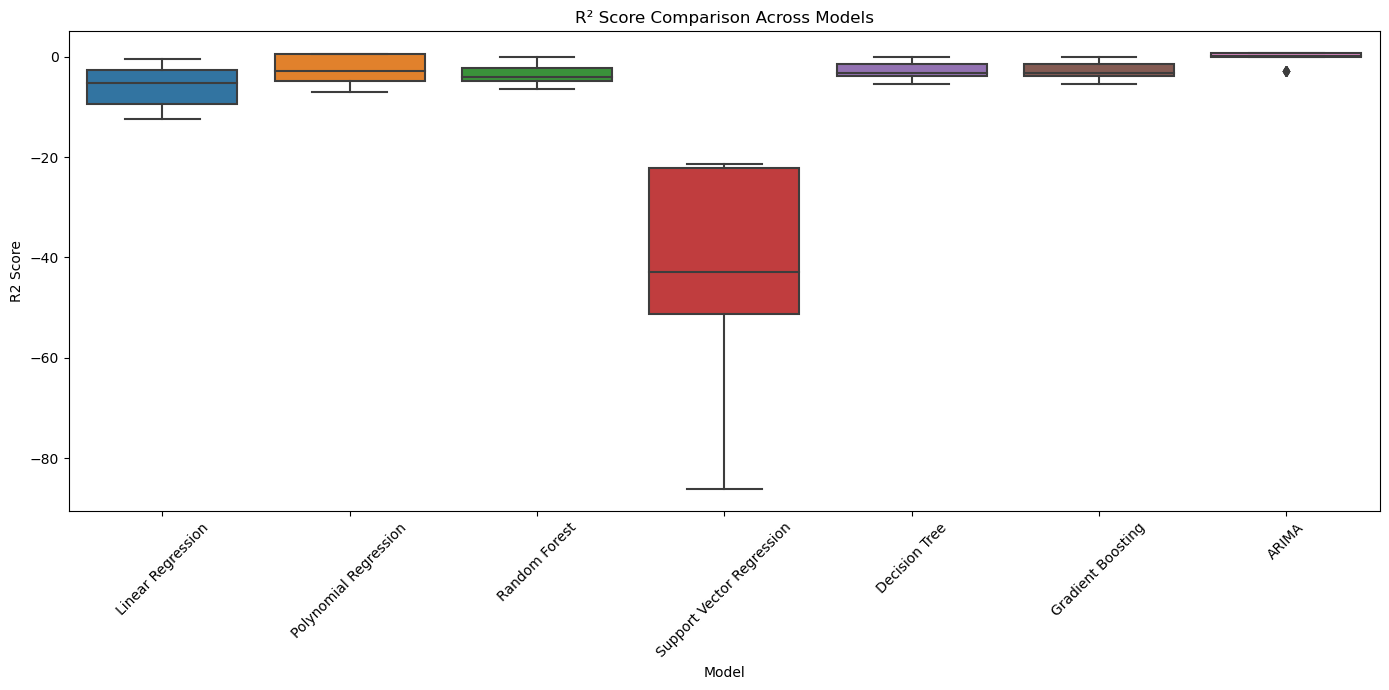

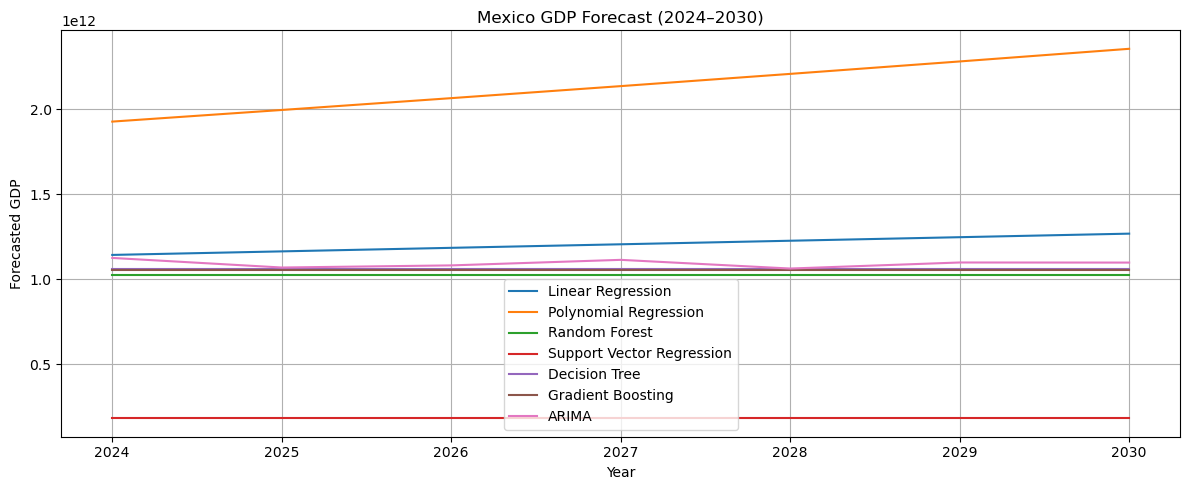

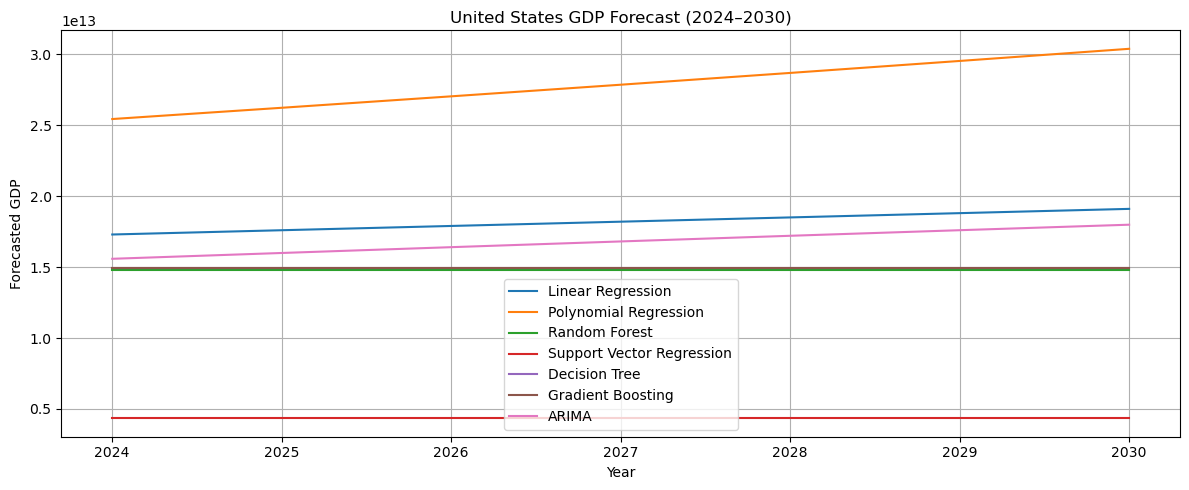

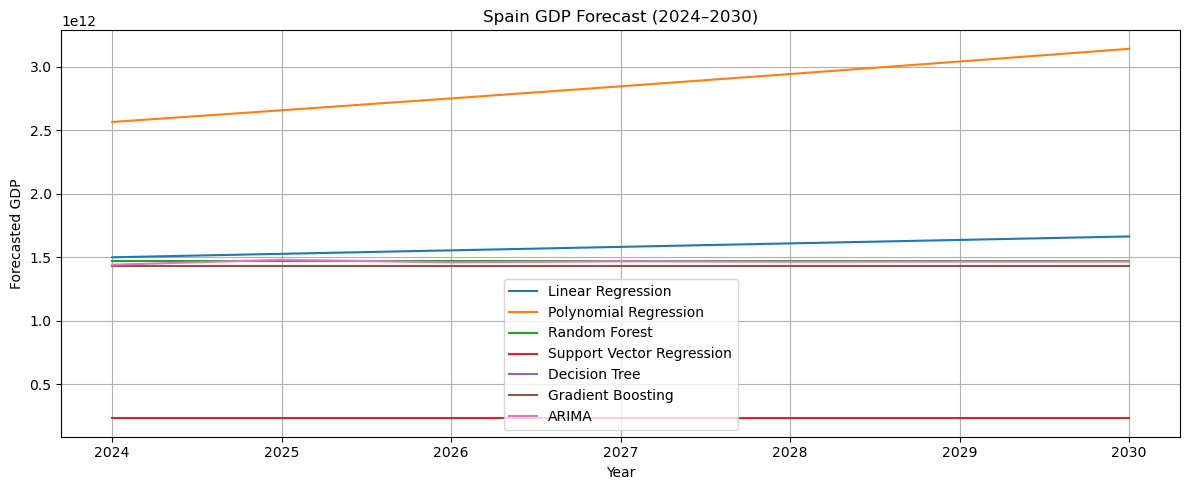

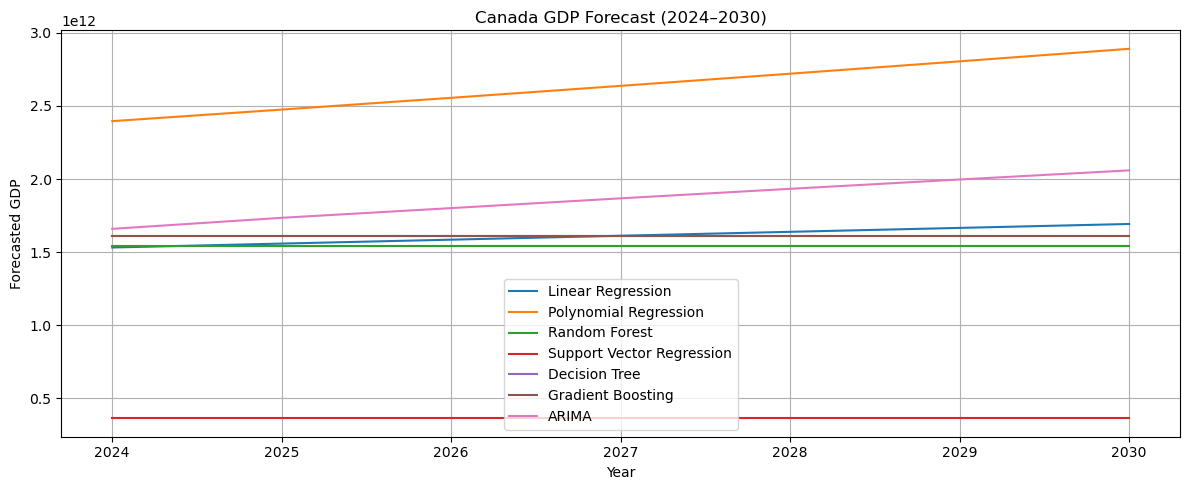

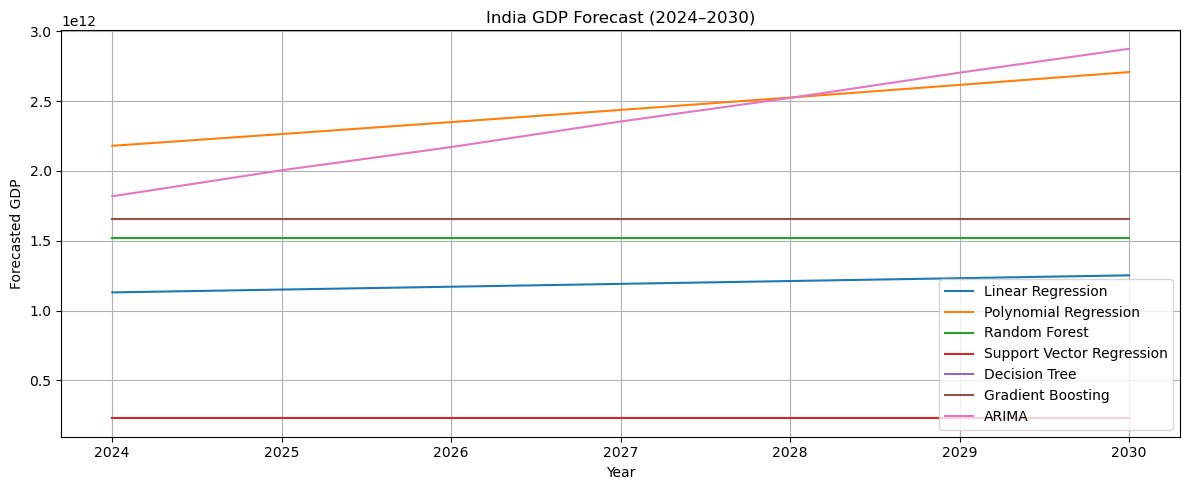

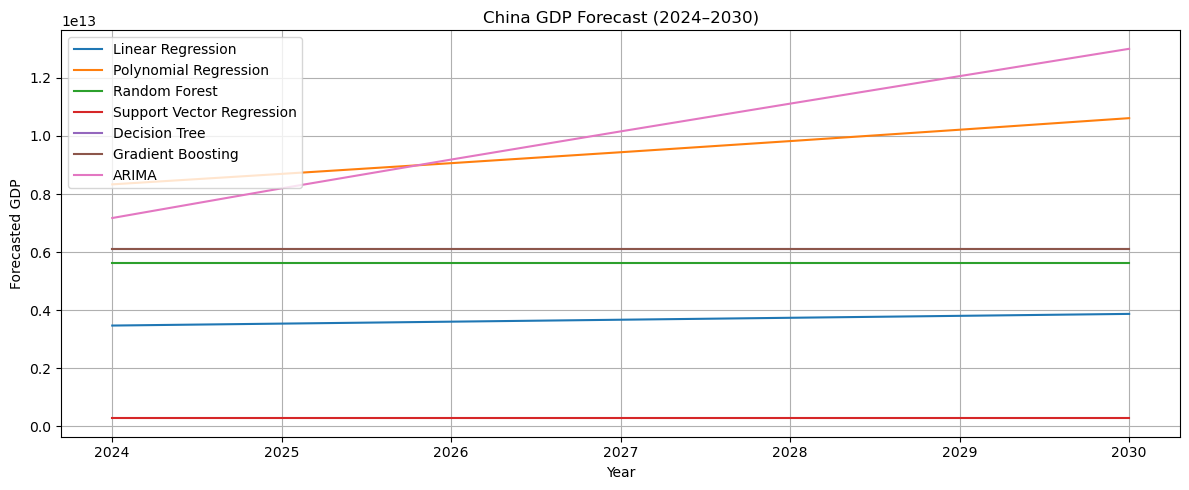

In [3]:
# GDP Forecasting for Multiple Countries using Machine Learning and Time Series Models

# File Path (Local)
data_path = "C:\\Users\\mehra\\Downloads\\Extended_GDP_2018_2023.csv"

# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
df = pd.read_csv(data_path)
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
df = pd.melt(df, id_vars=id_vars, var_name='year', value_name='GDP')
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna()
df['year'] = df['year'].astype(int)
df.rename(columns={'Country Name': 'Country'}, inplace=True)
df = df[['Country', 'year', 'GDP']]

# Target countries
countries = ['Mexico', 'United States', 'Spain', 'Canada', 'India', 'China']
future_years = np.arange(2024, 2031).reshape(-1, 1)

# Models
total_results = []
model_dict = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'Support Vector Regression': SVR(kernel='rbf', C=1e3, gamma=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=0)
}

# Model Execution
for country in countries:
    df_country = df[df['Country'] == country].sort_values(by='year')
    X = df_country['year'].values.reshape(-1, 1)
    y = df_country['GDP'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    future_poly = poly.transform(future_years)

    for model_name, model in model_dict.items():
        try:
            if model_name == 'Polynomial Regression':
                model.fit(X_train_poly, y_train)
                preds = model.predict(X_test_poly)
                future_preds = model.predict(future_poly)
            elif model_name == 'Support Vector Regression':
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)
            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                future_preds = model.predict(future_years)

            r2 = r2_score(y_test, preds)

            for i, year in enumerate(future_years.flatten()):
                total_results.append({
                    'Country': country,
                    'Model': model_name,
                    'Year': year,
                    'Forecasted GDP': future_preds[i],
                    'R2 Score': r2
                })

        except Exception as e:
            continue

    # Add ARIMA Model
    try:
        arima_model = ARIMA(y_train, order=(2, 1, 2)).fit()
        arima_forecast = arima_model.forecast(steps=len(future_years))
        arima_preds = arima_model.forecast(steps=len(y_test))
        arima_r2 = r2_score(y_test, arima_preds)

        for i, year in enumerate(future_years.flatten()):
            total_results.append({
                'Country': country,
                'Model': 'ARIMA',
                'Year': year,
                'Forecasted GDP': arima_forecast[i],
                'R2 Score': arima_r2
            })
    except:
        pass

# Create forecast DataFrame
forecast_df = pd.DataFrame(total_results)

# Save to CSV
forecast_df.to_csv("GDP_Forecasts_2024_2030.csv", index=False)

# Visualizations
plt.figure(figsize=(14, 7))
sns.boxplot(data=forecast_df, x='Model', y='R2 Score')
plt.title('R² Score Comparison Across Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Line plots for each country
for country in countries:
    plt.figure(figsize=(12, 5))
    subset = forecast_df[forecast_df['Country'] == country]
    for model in subset['Model'].unique():
        model_data = subset[subset['Model'] == model]
        plt.plot(model_data['Year'], model_data['Forecasted GDP'], label=model)
    plt.title(f"{country} GDP Forecast (2024–2030)")
    plt.xlabel("Year")
    plt.ylabel("Forecasted GDP")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
